# Customer Segmentation Analysis using RFM Metrics

This notebook performs customer segmentation analysis on an e-commerce dataset using Recency, Frequency, and Monetary (RFM) metrics. It includes data preprocessing, exploratory data analysis, customer segmentation, and clustering using KMeans.

## 1. Import Libraries

We start by importing the necessary libraries for data manipulation, visualization, and machine learning.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import warnings

## 2. Load the Dataset

Load the e-commerce dataset and display the first few rows to understand its structure.


In [2]:
df = pd.read_excel(r"C:\ML Datasets\ecommerce dataset\online_retail_II.xlsx")
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 3. Data Overview

Check the dataset for data types, non-null counts, and summary statistics.


In [3]:
df.info()  # Data types and non-null counts
df.describe()  # Summary statistics


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


## 4. Data Cleaning

### Handling Missing Values and Duplicates

- Check for missing values and duplicates.
- Remove duplicates and drop rows with missing Customer IDs or Descriptions.


In [4]:
df.isnull().sum()  # Check for missing values
df.duplicated().sum()  # Check for duplicates

df = df.drop_duplicates()  # Remove duplicates
df.dropna(subset=['Customer ID','Description'], inplace=True)  # Drop rows with missing values


### Calculate Total Sales

Create a new column `total_sales` which is the product of `Quantity` and `Price`.


In [5]:
df['total_sales'] = df['Quantity'] * df['Price']


## 5. Date Parsing

Convert the `InvoiceDate` column to a datetime object and extract year, month, day of the week, and hour.


In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['year'] = df['InvoiceDate'].dt.year
df['month'] = df['InvoiceDate'].dt.month
df['dayofweek'] = df['InvoiceDate'].dt.dayofweek
df['hour'] = df['InvoiceDate'].dt.hour


## 6. Filtering Data

Filter the data to include only positive Quantity and Price values.


In [7]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]


## 7. Univariate Analysis

### Country-wise Sales Distribution

Visualize sales distribution by country.


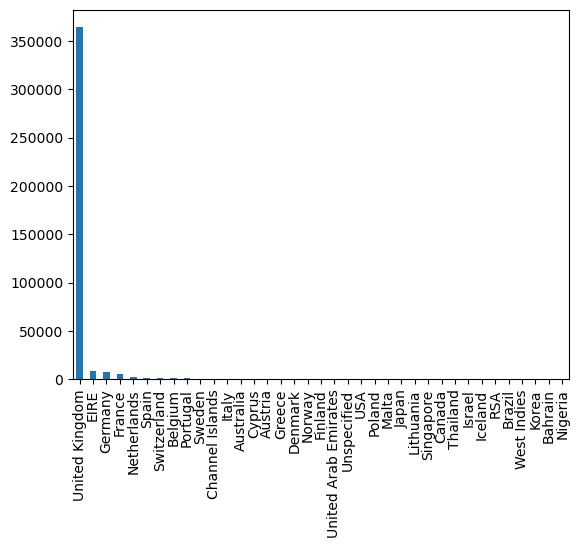

In [9]:
df['Country'].value_counts().plot(kind='bar')
plt.show()

### Total Sales Histogram

Visualize the distribution of total sales using a histogram.


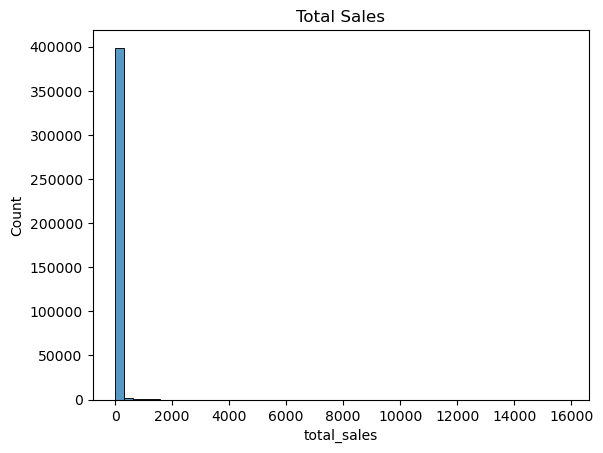

In [12]:
sns.histplot(df['total_sales'], bins=50)
plt.title('Total Sales')
plt.show()


### Monthly Sales Trends

Aggregate total sales by month and year, then visualize the trends.


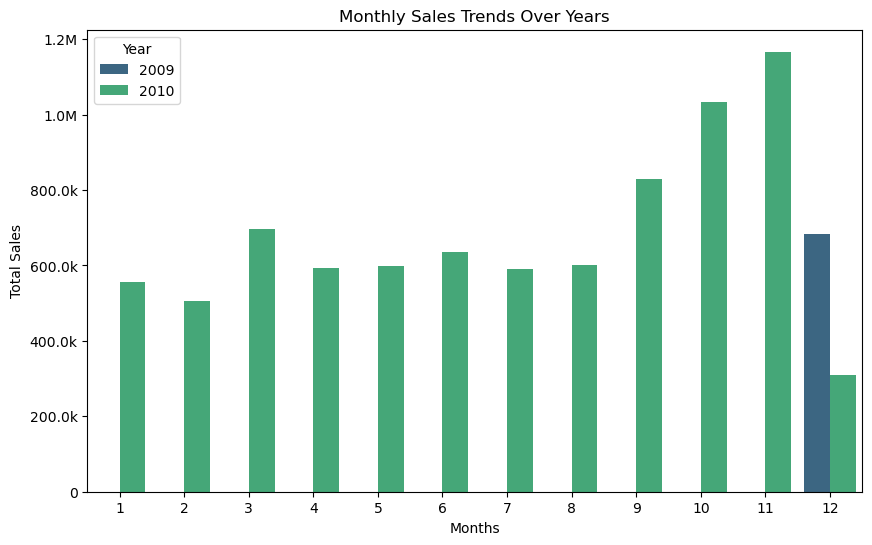

In [13]:
monthly_sales = df.groupby(['year', 'month'])['total_sales'].sum().reset_index()

def format_thousands(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.1f}M'  # Millions
    elif x >= 1e3:
        return f'{x*1e-3:.1f}k'  # Thousands
    else:
        return f'{x:.0f}'  # Ones

plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='total_sales', hue='year', data=monthly_sales, palette='viridis')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(format_thousands))
plt.title('Monthly Sales Trends Over Years')
plt.xlabel('Months')
plt.ylabel('Total Sales')
plt.legend(title='Year', loc=2)
plt.show()


## 8. Sales by Day of the Week

Aggregate total sales by day of the week and visualize.


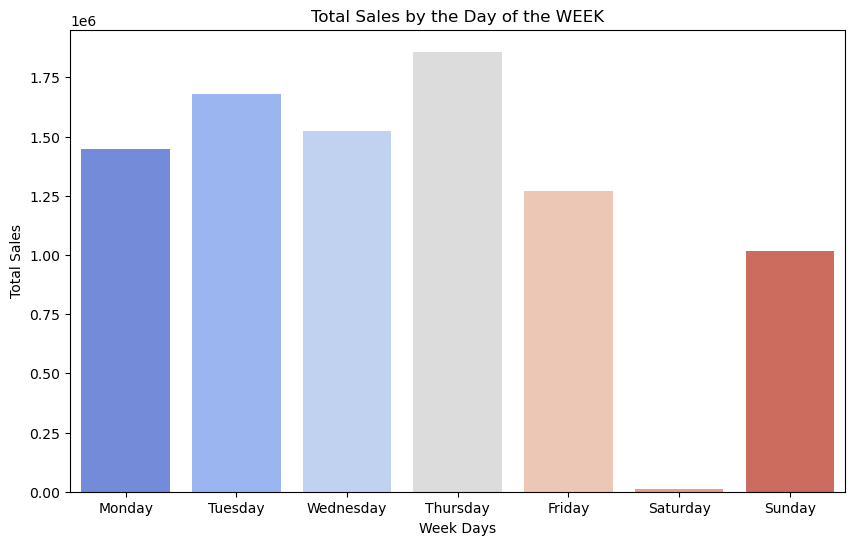

In [14]:
weekday_sales = df.groupby('dayofweek')['total_sales'].sum().reset_index()
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
weekday_sales['dayofweek'] = weekday_sales['dayofweek'].map(day_names)

plt.figure(figsize=(10, 6))
sns.barplot(x='dayofweek', y='total_sales', data=weekday_sales, palette='coolwarm')
plt.xlabel('Week Days')
plt.ylabel('Total Sales')
plt.title('Total Sales by the Day of the WEEK')
plt.show()


## 9. Sales by Hour

Aggregate total sales by hour and visualize.


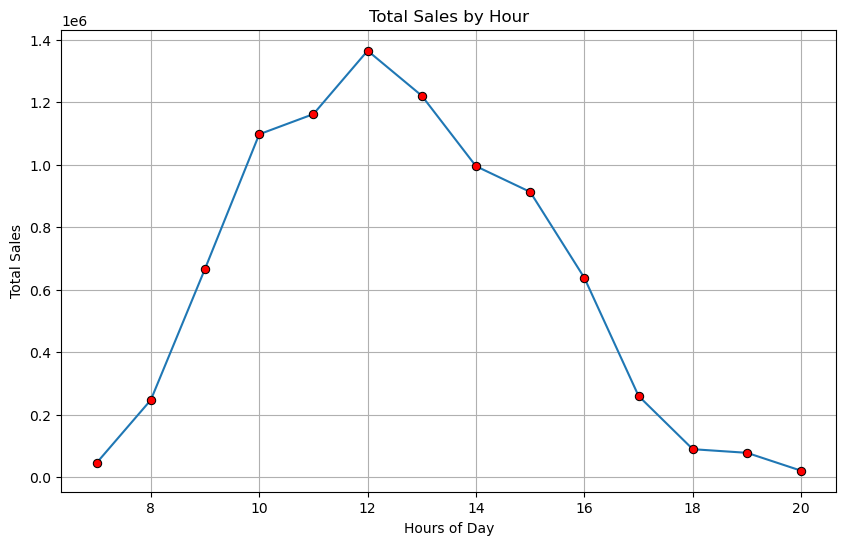

In [15]:
salesby_hour = df.groupby('hour')['total_sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='total_sales', data=salesby_hour, marker='o', markerfacecolor='red', markeredgecolor='black')
plt.title('Total Sales by Hour')
plt.xlabel('Hours of Day')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


## 10. Customer Segmentation using RFM Metrics

Calculate RFM metrics for customer segmentation.


In [16]:
refernence_date = df['InvoiceDate'].max()  # Reference date for recency

# Calculate Recency
recency_df = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (refernence_date - x.max()).days}).reset_index()
recency_df.columns = ['Customer ID', 'recency']

# Calculate Frequency
frequency_df = df.groupby('Customer ID').agg({'Invoice': 'nunique'}).reset_index()
frequency_df.columns = ['Customer ID', 'frequency']

# Calculate Monetary Value
monetary_df = df.groupby('Customer ID').agg({'total_sales': 'sum'}).reset_index()
monetary_df.columns = ['Customer ID', 'monetary']

# Merge RFM DataFrames
rfm = recency_df.merge(frequency_df, on='Customer ID').merge(monetary_df, on='Customer ID')


## 11. RFM Scoring

Assign scores for Recency, Frequency, and Monetary values.


In [17]:
rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm['score'] = rfm['r_score'].astype('str') + rfm['f_score'].astype('str') + rfm['m_score'].astype('str')


## 12. Customer Segmentation Based on RFM Scores

Define segments based on RFM scores.


In [18]:
def segment_customer(row):
    if row['r_score'] == '5' and row['f_score'] == '5' and row['m_score'] == '5':
        return 'Champions'
    elif row['r_score'] == '5' and int(row['f_score']) >= 3:
        return 'Loyal Customers'
    elif int(row['r_score']) >= 4 and int(row['f_score']) >= 3:
        return 'Potential Loyalists'
    elif int(row['r_score']) <= 2 and int(row['f_score']) >= 2:
        return 'At Risk'
    elif row['r_score'] == '1' and row['f_score'] == '1':
        return 'LOST'
    else:
        return 'Others'

rfm['segment'] = rfm.apply(segment_customer, axis=1)


## 13. Segmentation Visualization

Visualize the segments of customers.


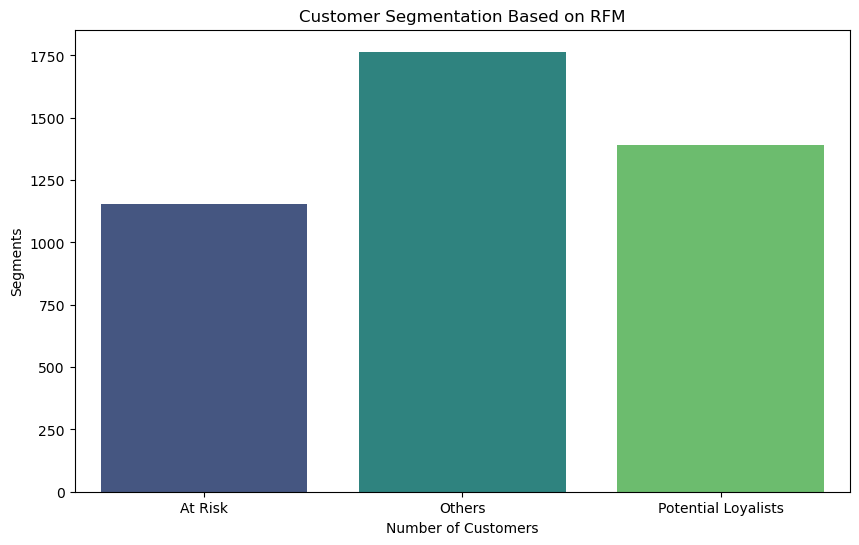

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='segment', data=rfm, palette='viridis')
plt.title('Customer Segmentation Based on RFM')
plt.xlabel('Number of Customers')
plt.ylabel('Segments')
plt.show()


## Customer Segmentation Analysis Using RFM

In this notebook, we analyze customer behavior using the RFM (Recency, Frequency, Monetary) model and perform clustering to segment customers into distinct groups based on their purchasing behavior. This approach helps in identifying customer segments for targeted marketing strategies.

## 14. Initial Data Exploration

Let's begin by loading the RFM DataFrame and examining its structure and contents.




In [24]:
# Get a concise summary of the DataFrame, including data types and non-null counts
rfm.head()



,Customer ID,recency,frequency,monetary,r_score,f_score,m_score,score,segment
0,12346.0,164,11,372.86,2,5,2,252,At Risk
1,12347.0,2,2,1323.32,5,2,4,524,Others
2,12348.0,73,1,222.16,2,1,1,211,Others
3,12349.0,42,3,2671.14,3,3,5,335,Others
4,12351.0,10,1,300.93,5,1,2,512,Others


In [25]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4312 entries, 0 to 4311
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Customer ID  4312 non-null   float64 
 1   recency      4312 non-null   int64   
 2   frequency    4312 non-null   int64   
 3   monetary     4312 non-null   float64 
 4   r_score      4312 non-null   category
 5   f_score      4312 non-null   category
 6   m_score      4312 non-null   category
 7   score        4312 non-null   object  
 8   segment      4312 non-null   object  
dtypes: category(3), float64(2), int64(2), object(2)
memory usage: 249.1+ KB


## 15.Data Scaling
To prepare the data for clustering, we need to scale the RFM values. StandardScaler is used to standardize the features by removing the mean and scaling to unit variance.

In [26]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
sc = StandardScaler()

# Fit and transform the RFM features for scaling
rfm_scaled = sc.fit_transform(rfm[['recency', 'frequency', 'monetary']])


## 16.Finding Optimal Clusters Using the Elbow Method
We use the Elbow Method to determine the optimal number of clusters for KMeans clustering. The Within-Cluster Sum of Squares (WCSS) is calculated for a range of cluster numbers.

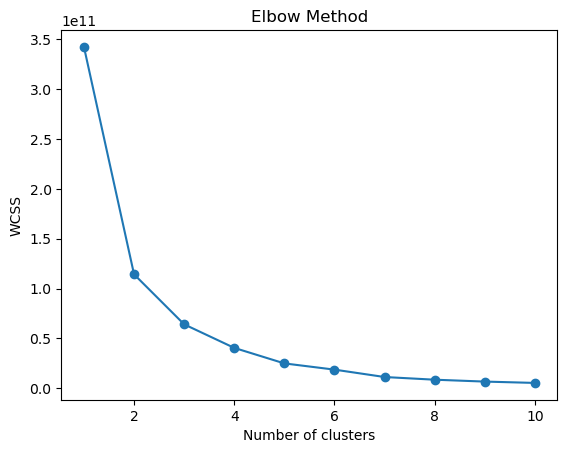

In [28]:
from sklearn.cluster import KMeans

wcss = []  # List to store WCSS values

# Calculate WCSS for cluster numbers from 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto', random_state=42)
    kmeans.fit(rfm[['recency', 'frequency', 'monetary']])
    wcss.append(kmeans.inertia_)  # Append WCSS value


# Enhanced Elbow plot with markers
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


## 17.Applying KMeans Clustering
Based on the Elbow method analysis, we choose the optimal number of clusters (e.g., 4) and fit the KMeans model.

In [29]:
# Create KMeans model with 4 clusters
kmeans2 = KMeans(n_clusters=4, n_init='auto', init='k-means++', random_state=42)
kmeans2.fit(rfm[['recency', 'frequency', 'monetary']])

# Assign cluster labels to the original DataFrame
rfm['cluster'] = kmeans2.predict(rfm[['recency', 'frequency', 'monetary']])


##  18.Cluster Summary Statistics
We compute the mean RFM values for each cluster to understand the characteristics of each segment.

In [30]:
# Group by cluster and calculate mean RFM values
cluster_summary = rfm.groupby('cluster')[['recency', 'frequency', 'monetary']].mean()
print(cluster_summary)


           recency  frequency       monetary
cluster                                     
0        32.535088  23.201754   16387.808360
1         5.000000  89.666667  264703.530000
2        92.066714   3.651602    1234.709288
3         5.692308  79.076923   74796.827692


## 19.Visualizing Clusters in 3D
To visualize the clustering results, we create a 3D scatter plot showing the clusters based on Recency, Frequency, and Monetary values.



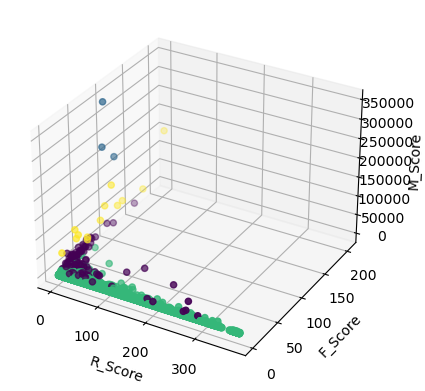

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# 3D scatter plot for visualizing clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm['recency'], rfm['frequency'], rfm['monetary'], c=rfm['cluster'], cmap='viridis')
ax.set_xlabel('R_Score')
ax.set_ylabel('F_Score')
ax.set_zlabel('M_Score')
plt.show()


## 20.Cluster Profiles
We create a summary DataFrame that provides insights into the average characteristics of customers in each cluster, including customer count.

In [32]:
# Aggregate to create cluster profiles
cluster_profiles = rfm.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'Customer ID': 'count'
}).rename(columns={'Customer ID': 'count'}).reset_index()
print(cluster_profiles)


   cluster    recency  frequency       monetary  count
0        0  32.535088  23.201754   16387.808360    114
1        1   5.000000  89.666667  264703.530000      3
2        2  92.066714   3.651602    1234.709288   4182
3        3   5.692308  79.076923   74796.827692     13


## 21.Visualization of Recency vs. Monetary
Next, we visualize customer segments based on their Recency and Monetary values using a scatter plot.

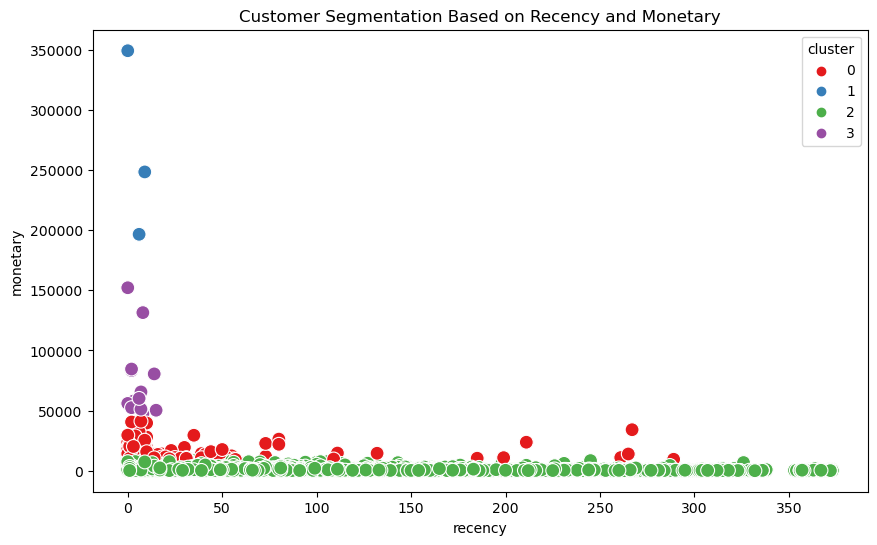

In [33]:
# Scatter plot for Recency vs Monetary colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='recency', y='monetary', hue='cluster', data=rfm, palette='Set1', s=100)
plt.title('Customer Segmentation Based on Recency and Monetary')
plt.show()


## 22.Assigning Meaningful Segment Labels
We define a function to assign meaningful labels to each cluster based on their characteristics.

In [34]:
def assign_cluster(cluster):
    if cluster == 0:
        return 'Moderate Engagement'
    elif cluster == 1:
        return 'VIP Customers'
    elif cluster == 2:
        return 'Low Engagement'
    elif cluster == 3:
        return 'Moderate Spending'
    
# Apply the function to create a new column for segment labels
rfm['segment_label'] = rfm['cluster'].apply(assign_cluster)


## 23.Final Output
Finally, we save the segmented customer data to a CSV file for further analysis or reporting.

In [35]:
# Save the RFM DataFrame with cluster labels to a CSV file
rfm.to_csv('customer_segments.csv', index=False)


## 24. Marketing Strategies Based on Customer Segments

Based on the customer segments identified through clustering, here are the tailored marketing strategies for each group:

### 1. **Moderate Engagement** (Cluster 0)
- Send personalized product recommendations to increase their interaction.
- Offer exclusive discounts to encourage more frequent purchases.
- Use retargeting ads to remind them of products they have shown interest in but haven't purchased.

### 2. **VIP Customers** (Cluster 1)
- Provide loyalty rewards, such as points or VIP-exclusive offers.
- Organize exclusive events or early access to product launches.
- Maintain personalized communication (e.g., thank-you notes, birthday offers) to reinforce loyalty.

### 3. **Low Engagement** (Cluster 2)
- Launch win-back campaigns, offering personalized discounts to re-engage them.
- Offer incentives for completing specific actions (e.g., discounts on next purchase).
- Run re-engagement email campaigns with targeted product recommendations and savings.

### 4. **Moderate Spending** (Cluster 3)
- Encourage repeat purchases by offering rewards or discounts after a certain number of transactions.
- Introduce bundled deals or upselling offers to increase transaction size.
- Provide personalized product recommendations focusing on high-value items within their spending range.
